## 6.4.1. Dataset enrichment

## Table of contents:
### 1. Import libraries and main dataset
### 2. Enrich data with new dataset
#### 2.1. agriculture_prod_import_export dataset: data cleaning
#### 2.2.  gdp dataset: data cleaning
#### 2.3. gross_production_value dataset: data cleaning
#### 2.4. Merge dataframes into the main one
### 3. Exploratory analysis for the enriched dataframe
##

### 1. Import libraries and main dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [2]:
# Create path
path = r'C:\Users\marta\OneDrive\Documents\A6 Personal Project'

In [3]:
# Import dataset
df_emission = pd.read_pickle(r'C:\Users\marta\OneDrive\Documents\A6 Personal Project\02 Data\Prepared Data\emissions_temp_pop_country_modified.pkl')

In [4]:
# Check output
df_emission.head(3)

,country,country_code,agriculture_prod_stage,year,temp_change,total_population,emissions_CH4,emissions_CO2,emissions_N2O,population_category,total_emissions
0,Afghanistan,4,Domestic Wastewater,2002,1.365,21000.256,28.870985,141.322891,0.411351,Low population,170.605227
1,Afghanistan,4,Domestic Wastewater,2003,0.587,22645.130,30.250737,141.322891,0.440623,Low population,172.014251
2,Afghanistan,4,Domestic Wastewater,2004,1.373,23553.551,31.586700,141.322891,0.465987,Low population,173.375578


In [5]:
# Check shape
df_emission.shape

(35780, 11)

### 2. Enrich data with new datasets

### 2.1. agriculture_prod_import_export dataset: data cleaning

In [6]:
# Import agriculture_prod_import_export dataset 
df_trade = pd.read_csv(r'C:\Users\marta\OneDrive\Documents\A6 Personal Project\02 Data\Original Data\agriculture_prod_import_export.csv')

In [7]:
# Check output
df_trade.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Value
0,TCL,Crops and livestock products,4,Afghanistan,5622,Import Value,F1882,Agricultural Products,2002,2002,303167.0
1,TCL,Crops and livestock products,4,Afghanistan,5922,Export Value,F1882,Agricultural Products,2002,2002,35964.0
2,TCL,Crops and livestock products,4,Afghanistan,5622,Import Value,F1882,Agricultural Products,2003,2003,451001.0
3,TCL,Crops and livestock products,4,Afghanistan,5922,Export Value,F1882,Agricultural Products,2003,2003,58782.0
4,TCL,Crops and livestock products,4,Afghanistan,5622,Import Value,F1882,Agricultural Products,2004,2004,500790.0


In [8]:
# Check shape
df_trade.shape

(7799, 11)

#### -- Drop and rename columns

In [9]:
# Remove irrelevant columns (not needed for the analysis)
df_trade = df_trade.drop(columns = ['Domain Code', 'Domain', 'Area', 'Element Code', 'Item Code (CPC)', 'Item', 'Year Code'])

In [10]:
# Check result
df_trade.columns

Index(['Area Code (M49)', 'Element', 'Year', 'Value'], dtype='object')

In [11]:
# Rename columns 
df_trade.rename(columns = {'Area Code (M49)' : 'country_code', 'Element' : 'trade_category',
                               'Year' : 'year', 'Value': 'import_export_amount'}, inplace = True)

In [12]:
# Check results
df_trade.head(2)

,country_code,trade_category,year,import_export_amount
0,4,Import Value,2002,303167.0
1,4,Export Value,2002,35964.0


#### -- Check column types and missing values

In [13]:
# Check missing values
df_trade.isnull().sum() # No missing values

country_code            0
trade_category          0
year                    0
import_export_amount    0
dtype: int64

In [14]:
# Check column type
df_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7799 entries, 0 to 7798
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_code          7799 non-null   int64  
 1   trade_category        7799 non-null   object 
 2   year                  7799 non-null   int64  
 3   import_export_amount  7799 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 243.8+ KB


#### -- Check for duplicates and mixed type data

In [15]:
# Create a subset dataframe with only duplicated values
df_dups_1 = df_trade[df_trade.duplicated()]

In [16]:
# Check result
df_dups_1 # No duplicates found

,country_code,trade_category,year,import_export_amount


In [17]:
# Check for mixed-type columns
for col in df_trade.columns.tolist():
  weird = (df_trade[[col]].applymap(type) != df_trade[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_trade[weird]) > 0:
    print (col) # No mixed-type data

#### -- Transpose categorical data into separate columns

In [18]:
# Use set_index to move specified columns into index, then unstack to move the 'emission_gas' index level into the column index
df_imp_exp = df_trade.set_index(['country_code', 'year', 'trade_category']).unstack(['trade_category'])

In [19]:
# Join multiindex into one index
df_imp_exp.columns = [' '.join(col).strip() for col in df_imp_exp.columns.values]

In [20]:
df_imp_exp.head()

import_export_amount Export Value  \
country_code year                                      
4            2002                            35964.0   
             2003                            58782.0   
             2004                            64919.0   
             2005                            78944.0   
             2006                            79550.0   

                   import_export_amount Import Value  
country_code year                                     
4            2002                           303167.0  
             2003                           451001.0  
             2004                           500790.0  
             2005                           743294.0  
             2006                           806212.0

In [21]:
# Flatten the index at all levels
df_imp_exp = pd.DataFrame(df_imp_exp.to_records())

In [22]:
# Rename columns 
df_imp_exp.rename(columns = {'import_export_amount Export Value' : 'agric_export',
                             'import_export_amount Import Value' : 'agric_import'}, inplace = True)

In [23]:
# Check output
df_imp_exp.head()

,country_code,year,agric_export,agric_import
0,4,2002,35964.0,303167.0
1,4,2003,58782.0,451001.0
2,4,2004,64919.0,500790.0
3,4,2005,78944.0,743294.0
4,4,2006,79550.0,806212.0


#### -- Descriptive statistics

In [24]:
# Descriptive statistics
df_imp_exp.describe()

,country_code,year,agric_export,agric_import
count,3906.000000,3906.000000,3.893000e+03,3.906000e+03
mean,424.963134,2011.520993,5.975280e+06,6.489285e+06
std,252.504494,5.764139,1.550698e+07,1.722445e+07
min,4.000000,2002.000000,0.000000e+00,8.070000e+02
25%,204.000000,2007.000000,6.893205e+04,3.209540e+05
50%,417.000000,2012.000000,5.672226e+05,1.093100e+06
75%,643.000000,2017.000000,3.462901e+06,4.548834e+06
max,894.000000,2021.000000,1.737026e+08,2.446301e+08


### 2.2.  gdp dataset: data cleaning

In [25]:
# Import gdp dataset
df_gdp = pd.read_csv(r'C:\Users\marta\OneDrive\Documents\A6 Personal Project\02 Data\Original Data\gdp.csv')

In [26]:
# Check output
df_gdp.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Value
0,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2002,2002,4141.523943
1,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2003,2003,4729.042179
2,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2004,2004,5388.482107
3,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2005,2005,6220.574147
4,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2006,2006,7104.711445


In [27]:
# Check shape
df_gdp.shape

(4219, 11)

#### -- Drop and rename columns

In [28]:
# Remove irrelevant columns (not needed for the analysis)
df_gdp = df_gdp.drop(columns = ['Domain Code', 'Domain', 'Area', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code'])

In [29]:
# Check the output
df_gdp.head(3)

,Area Code (M49),Year,Value
0,4,2002,4141.523943
1,4,2003,4729.042179
2,4,2004,5388.482107


In [30]:
# Rename columns 
df_gdp.rename(columns = {'Area Code (M49)' : 'country_code', 'Year' : 'year', 'Value': 'gdp'}, inplace = True)

In [31]:
# Check the output
df_gdp.columns

Index(['country_code', 'year', 'gdp'], dtype='object')

#### -- Check column types and missing values

In [32]:
# Check missing values
df_gdp.isnull().sum() # No misisng values

country_code    0
year            0
gdp             0
dtype: int64

In [33]:
# Check column type
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219 entries, 0 to 4218
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  4219 non-null   int64  
 1   year          4219 non-null   int64  
 2   gdp           4219 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 99.0 KB


#### -- Check for duplicates and mixed type data

In [34]:
# Create a subset dataframe with only duplicated values
df_dups_2 = df_gdp[df_gdp.duplicated()]

In [35]:
# Check result
df_dups_2 # No duplicates

,country_code,year,gdp


In [36]:
# Check for mixed-type columns  # No mixed-type data
for col in df_gdp.columns.tolist():
  weird = (df_gdp[[col]].applymap(type) != df_gdp[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_gdp[weird]) > 0:
    print (col)

#### -- Descriptive statistics

In [37]:
# Descriptive statistics
df_gdp.describe()

,country_code,year,gdp
count,4219.000000,4219.000000,4.219000e+03
mean,429.108557,2011.510311,3.604800e+05
std,250.482627,5.759078,1.567036e+06
min,4.000000,2002.000000,1.553408e+01
25%,208.000000,2007.000000,4.326021e+03
50%,430.000000,2012.000000,1.879247e+04
75%,642.000000,2016.500000,1.346390e+05
max,894.000000,2021.000000,2.331508e+07


### 2.3. gross_production_value dataset: data cleaning

In [38]:
# Import gross_production_value dataset
df_prod_value = pd.read_csv(r'C:\Users\marta\OneDrive\Documents\A6 Personal Project\02 Data\Original Data\gross_production_value.csv')

In [39]:
# Check output
df_prod_value.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Value
0,QV,Value of Agricultural Production,8,Albania,57,Gross Production Value (current thousand US$),F2051,Agriculture,2002,2002,975106
1,QV,Value of Agricultural Production,8,Albania,57,Gross Production Value (current thousand US$),F2051,Agriculture,2003,2003,1201160
2,QV,Value of Agricultural Production,8,Albania,57,Gross Production Value (current thousand US$),F2051,Agriculture,2004,2004,1464837
3,QV,Value of Agricultural Production,8,Albania,57,Gross Production Value (current thousand US$),F2051,Agriculture,2005,2005,1426050
4,QV,Value of Agricultural Production,8,Albania,57,Gross Production Value (current thousand US$),F2051,Agriculture,2006,2006,1501212


In [40]:
# Check the shape
df_prod_value.shape

(3060, 11)

#### -- Drop and rename columns

In [41]:
# Remove irrelevant columns (not needed for the analysis)
df_prod_value = df_prod_value.drop(columns = ['Domain Code', 'Domain', 'Area', 'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code'])

In [42]:
# Check result
df_prod_value.head(3)

,Area Code (M49),Year,Value
0,8,2002,975106
1,8,2003,1201160
2,8,2004,1464837


In [43]:
# Rename columns 
df_prod_value.rename(columns = {'Area Code (M49)' : 'country_code',
                        'Year' : 'year', 'Value': 'agric_gross_prod_value'}, inplace = True)

In [44]:
# Check the output
df_prod_value.head(3)

,country_code,year,agric_gross_prod_value
0,8,2002,975106
1,8,2003,1201160
2,8,2004,1464837


#### -- Check column types and missing values

In [45]:
# Check missing values
df_prod_value.isnull().sum() # No misisng values

country_code              0
year                      0
agric_gross_prod_value    0
dtype: int64

In [46]:
# Check column type
df_prod_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   country_code            3060 non-null   int64
 1   year                    3060 non-null   int64
 2   agric_gross_prod_value  3060 non-null   int64
dtypes: int64(3)
memory usage: 71.8 KB


#### -- Check for duplicates and mixed type data

In [47]:
# Create a subset dataframe with only duplicated values
df_dups_4 = df_prod_value[df_prod_value.duplicated()]

In [48]:
# Check for duplicates
df_dups_4 # No duplicates

,country_code,year,agric_gross_prod_value


In [49]:
# Check for mixed-type columns  # No mixed-type data
for col in df_prod_value.columns.tolist():
  weird = (df_prod_value[[col]].applymap(type) != df_prod_value[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_prod_value[weird]) > 0:
    print (col)

#### -- Descriptive statistics

In [50]:
# Descriptive statistics
df_prod_value.describe()

,country_code,year,agric_gross_prod_value
count,3060.000000,3060.000000,3.060000e+03
mean,421.525817,2011.695752,2.724838e+07
std,251.244506,5.741225,1.274548e+08
min,8.000000,2002.000000,9.900000e+01
25%,204.000000,2007.000000,7.844132e+05
50%,410.000000,2012.000000,3.335397e+06
75%,634.000000,2017.000000,1.211282e+07
max,894.000000,2021.000000,1.605839e+09


### 2.4. Merge dataframes into the main one

#### -- Aggregate main dataframe

In [51]:
# Aggregate sum of total_emissions, emissions_CO2, emissions_N2O, emissions_CH4 grouped by the rest of variables
df_aggr = df_emission.groupby(['country', 'year', 'country_code', 'temp_change', 'total_population', 'population_category',
                              ]).agg({'total_emissions': ['sum'],
                              'emissions_CO2': ['sum'],'emissions_N2O': ['sum'], 'emissions_CH4': ['sum']})

In [52]:
# Join multiindex into one index
df_aggr.columns = [' '.join(col).strip() for col in df_aggr.columns.values]

In [53]:
# Flatten the index at all levels
df_aggr = pd.DataFrame(df_aggr.to_records())

In [54]:
# Rename columns 
df_aggr.rename(columns = {'total_emissions sum' : 'total_emissions', 'emissions_CO2 sum' : 'emissions_CO2',
                               'emissions_N2O sum' : 'emissions_N2O', 'emissions_CH4 sum' : 'emissions_CH4'}, inplace = True)

In [55]:
# Check the result
df_aggr.head()

,country,year,country_code,temp_change,total_population,population_category,total_emissions,emissions_CO2,emissions_N2O,emissions_CH4
0,Afghanistan,2002,4,1.365,21000.256,Low population,695.719823,650.760809,0.524767,44.434247
1,Afghanistan,2003,4,0.587,22645.130,Low population,713.515557,662.122718,0.556194,50.836645
2,Afghanistan,2004,4,1.373,23553.551,Low population,704.272007,652.141129,0.494035,51.636843
3,Afghanistan,2005,4,0.401,24411.191,Low population,737.718469,679.839519,0.498897,57.380053
4,Afghanistan,2006,4,1.720,25442.944,Low population,771.563510,708.516693,0.512822,62.533995


In [56]:
# Check the shape
df_aggr.shape

(4305, 10)

In [57]:
# Export df_aggr
df_aggr.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'emissions_aggrigated.csv'))

#### -- Merge dataframes

In [58]:
# Merge df_trade into df_aggr
df_emiss_trade = df_aggr.merge(df_imp_exp, on = ['country_code','year'], how = 'inner')

In [59]:
# Check output
df_emiss_trade.head(5)

,country,year,country_code,temp_change,total_population,population_category,total_emissions,emissions_CO2,emissions_N2O,emissions_CH4,agric_export,agric_import
0,Afghanistan,2002,4,1.365,21000.256,Low population,695.719823,650.760809,0.524767,44.434247,35964.0,303167.0
1,Afghanistan,2003,4,0.587,22645.130,Low population,713.515557,662.122718,0.556194,50.836645,58782.0,451001.0
2,Afghanistan,2004,4,1.373,23553.551,Low population,704.272007,652.141129,0.494035,51.636843,64919.0,500790.0
3,Afghanistan,2005,4,0.401,24411.191,Low population,737.718469,679.839519,0.498897,57.380053,78944.0,743294.0
4,Afghanistan,2006,4,1.720,25442.944,Low population,771.563510,708.516693,0.512822,62.533995,79550.0,806212.0


In [60]:
# Check the shape
df_emiss_trade.shape

(3755, 12)

In [61]:
# Merge df_gdp into df_emiss_trade
df_emiss_trade_gdp = df_emiss_trade.merge(df_gdp, on = ['country_code','year'], how = 'left')

In [62]:
# Check the result
df_emiss_trade_gdp.shape

(3755, 13)

In [63]:
# Merge df_prod_value into df_emiss_trade_gdp
df_enriched = df_emiss_trade_gdp.merge(df_prod_value, on = ['country_code','year'], how = 'left')

In [64]:
# Check the shape
df_enriched.shape

(3755, 14)

In [65]:
# Check the output
df_enriched.head()

,country,year,country_code,temp_change,total_population,population_category,total_emissions,emissions_CO2,emissions_N2O,emissions_CH4,agric_export,agric_import,gdp,agric_gross_prod_value
0,Afghanistan,2002,4,1.365,21000.256,Low population,695.719823,650.760809,0.524767,44.434247,35964.0,303167.0,4141.523943,NaN
1,Afghanistan,2003,4,0.587,22645.130,Low population,713.515557,662.122718,0.556194,50.836645,58782.0,451001.0,4729.042179,NaN
2,Afghanistan,2004,4,1.373,23553.551,Low population,704.272007,652.141129,0.494035,51.636843,64919.0,500790.0,5388.482107,NaN
3,Afghanistan,2005,4,0.401,24411.191,Low population,737.718469,679.839519,0.498897,57.380053,78944.0,743294.0,6220.574147,NaN
4,Afghanistan,2006,4,1.720,25442.944,Low population,771.563510,708.516693,0.512822,62.533995,79550.0,806212.0,7104.711445,NaN


#### -- Address missing values in merged dataframe

In [66]:
# Check missing values
df_enriched.isnull().sum()

country                     0
year                        0
country_code                0
temp_change                 0
total_population            0
population_category         0
total_emissions             0
emissions_CO2               0
emissions_N2O               0
emissions_CH4               0
agric_export                1
agric_import                0
gdp                        47
agric_gross_prod_value    814
dtype: int64

Text(0.5, 1.0, 'Distribution of Gross Production Value for Agriculture')

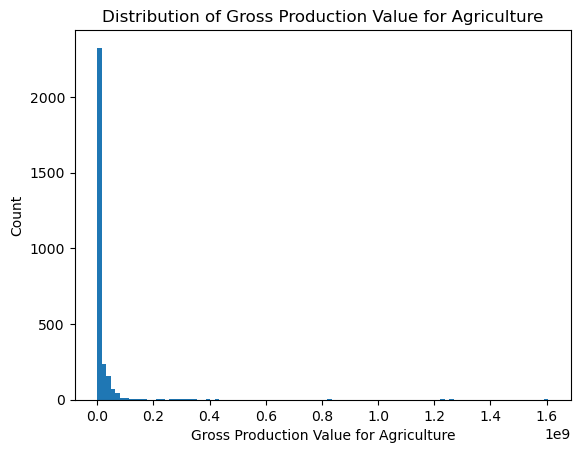

In [67]:
# Create histogram for 'agric_gross_prod_value' column
hist = df_enriched['agric_gross_prod_value'].plot.hist(bins = 100)
plt.xlabel('Gross Production Value for Agriculture')
plt.ylabel('Count')
plt.title('Distribution of Gross Production Value for Agriculture')

Text(0.5, 1.0, 'Distribution of GDP')

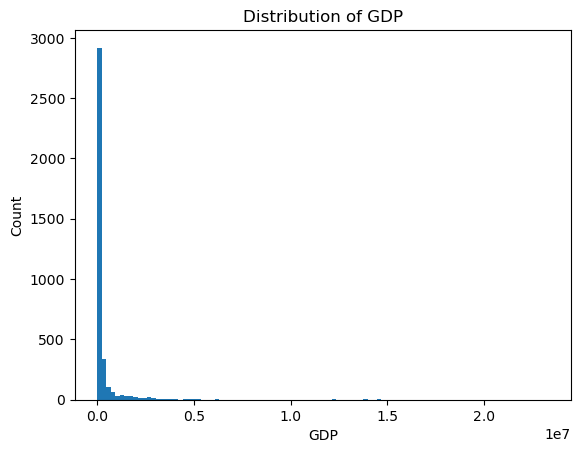

In [68]:
# Create histogram for 'gdp' column
hist = df_enriched['gdp'].plot.hist(bins = 100)
plt.xlabel('GDP')
plt.ylabel('Count')
plt.title('Distribution of GDP')

Text(0.5, 1.0, 'Distribution of Agriculture Export')

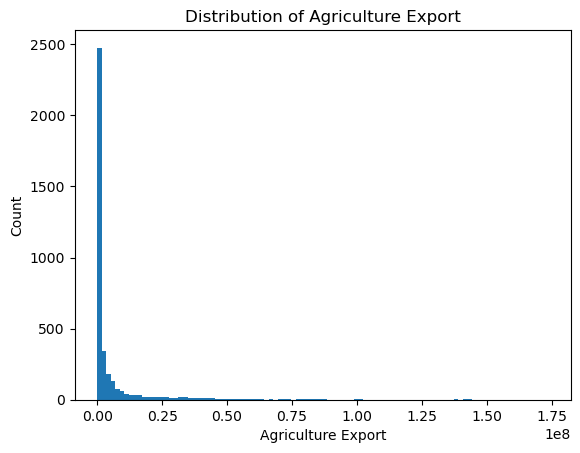

In [69]:
# Create histogram for 'gdp' column
hist = df_enriched['agric_export'].plot.hist(bins = 100)
plt.xlabel('Agriculture Export')
plt.ylabel('Count')
plt.title('Distribution of Agriculture Export')

In [70]:
# Impute missing values with the median value (as the distributions are right-skewed)
df_enriched['gdp'] = df_enriched['gdp'].fillna(df_enriched['gdp'].median())
df_enriched['agric_export'] = df_enriched['agric_export'].fillna(df_enriched['agric_export'].median())

In [71]:
# Check missing values for agric_gross_prod_value 
pd.set_option('display.max_rows', None)
df_enriched[df_enriched.isnull().any(axis=1)]

,country,year,country_code,temp_change,total_population,population_category,total_emissions,emissions_CO2,emissions_N2O,emissions_CH4,agric_export,agric_import,gdp,agric_gross_prod_value
0,Afghanistan,2002,4,1.365,21000.256,Low population,695.719823,650.760809,0.524767,44.434247,35964.00,303167.00,4141.523943,NaN
1,Afghanistan,2003,4,0.587,22645.130,Low population,713.515557,662.122718,0.556194,50.836645,58782.00,451001.00,4729.042179,NaN
2,Afghanistan,2004,4,1.373,23553.551,Low population,704.272007,652.141129,0.494035,51.636843,64919.00,500790.00,5388.482107,NaN
3,Afghanistan,2005,4,0.401,24411.191,Low population,737.718469,679.839519,0.498897,57.380053,78944.00,743294.00,6220.574147,NaN
4,Afghanistan,2006,4,1.720,25442.944,Low population,771.563510,708.516693,0.512822,62.533995,79550.00,806212.00,7104.711445,NaN
5,Afghanistan,2007,4,0.675,25903.301,Low population,792.736494,724.637239,0.551598,67.547657,167672.00,914274.00,9412.161765,NaN
6,Afghanistan,2008,4,0.704,26427.199,Low population,926.632712,853.694825,0.580433,72.357454,189423.00,1404917.00,10236.901594,NaN
7,Afghanistan,2009,4,0.895,27385.307,Low population,1141.488224,1063.873123,0.611145,77.003956,320583.00,1036681.00,11595.133469,NaN
8,Afghanistan,2010,4,1.613,28189.672,Low population,1318.519285,1236.183928,0.638412,81.696945,277114.00,1219839.00,14698.889678,NaN
9,Afghanistan,2011,4,1.397,29249.157,Low population,1593.142880,1506.123907,0.668593,86.350380,249481.00,1603412.00,17350.694945,NaN


In [72]:
# Impute missing values with the median value (as the distributions are right-skewed)
df_enriched['agric_gross_prod_value'] = df_enriched['agric_gross_prod_value'].fillna(df_enriched['agric_gross_prod_value'].median())

In [73]:
# # Check missing values
df_enriched.isnull().sum()

country                   0
year                      0
country_code              0
temp_change               0
total_population          0
population_category       0
total_emissions           0
emissions_CO2             0
emissions_N2O             0
emissions_CH4             0
agric_export              0
agric_import              0
gdp                       0
agric_gross_prod_value    0
dtype: int64

In [74]:
# Export df_enriched
df_enriched.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'emissions_macro_indicators_final.csv'))

### 3. Exploratory analysis for the enriched dataframe

### -- Correlation heatmap

In [75]:
# Create a subset dataframe with columns below
df_subset = df_enriched[['total_emissions', 'total_population', 'agric_import', 'agric_export', 'gdp', 'agric_gross_prod_value']]

In [76]:
# Check output
df_subset.head()

,total_emissions,total_population,agric_import,agric_export,gdp,agric_gross_prod_value
0,695.719823,21000.256,303167.0,35964.0,4141.523943,3403032.0
1,713.515557,22645.130,451001.0,58782.0,4729.042179,3403032.0
2,704.272007,23553.551,500790.0,64919.0,5388.482107,3403032.0
3,737.718469,24411.191,743294.0,78944.0,6220.574147,3403032.0
4,771.563510,25442.944,806212.0,79550.0,7104.711445,3403032.0


Text(0.5, 1.0, 'Correlation Matrix')

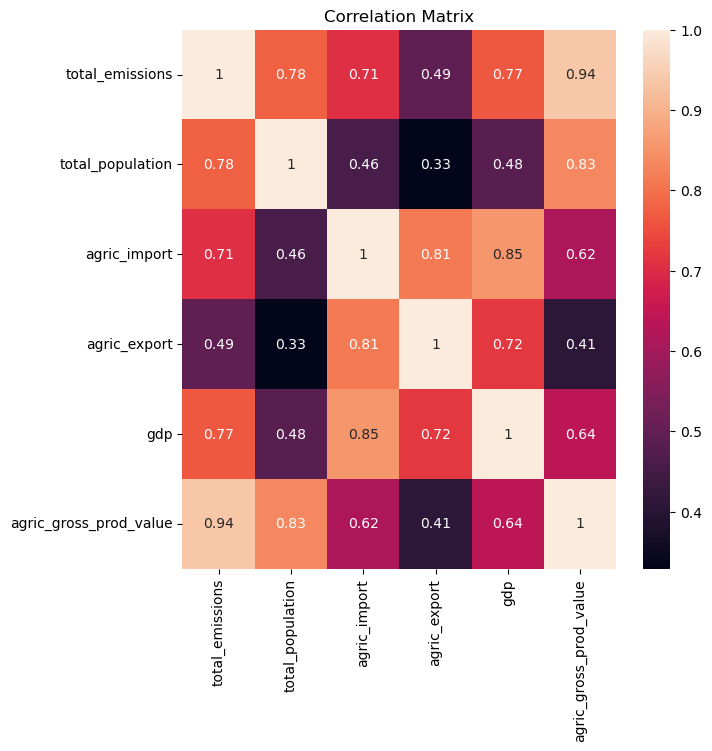

In [77]:
# Create heatmap using seaborn
f,ax = plt.subplots(figsize=(7,7))
corr_all = sns.heatmap(df_subset.corr(), annot = True, ax = ax)
plt.title('Correlation Matrix', fontsize=12)

In [78]:
# Export heatmap
corr_all.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'corr_heatmap_enriched.png'),bbox_inches='tight')


### -- Pairplot

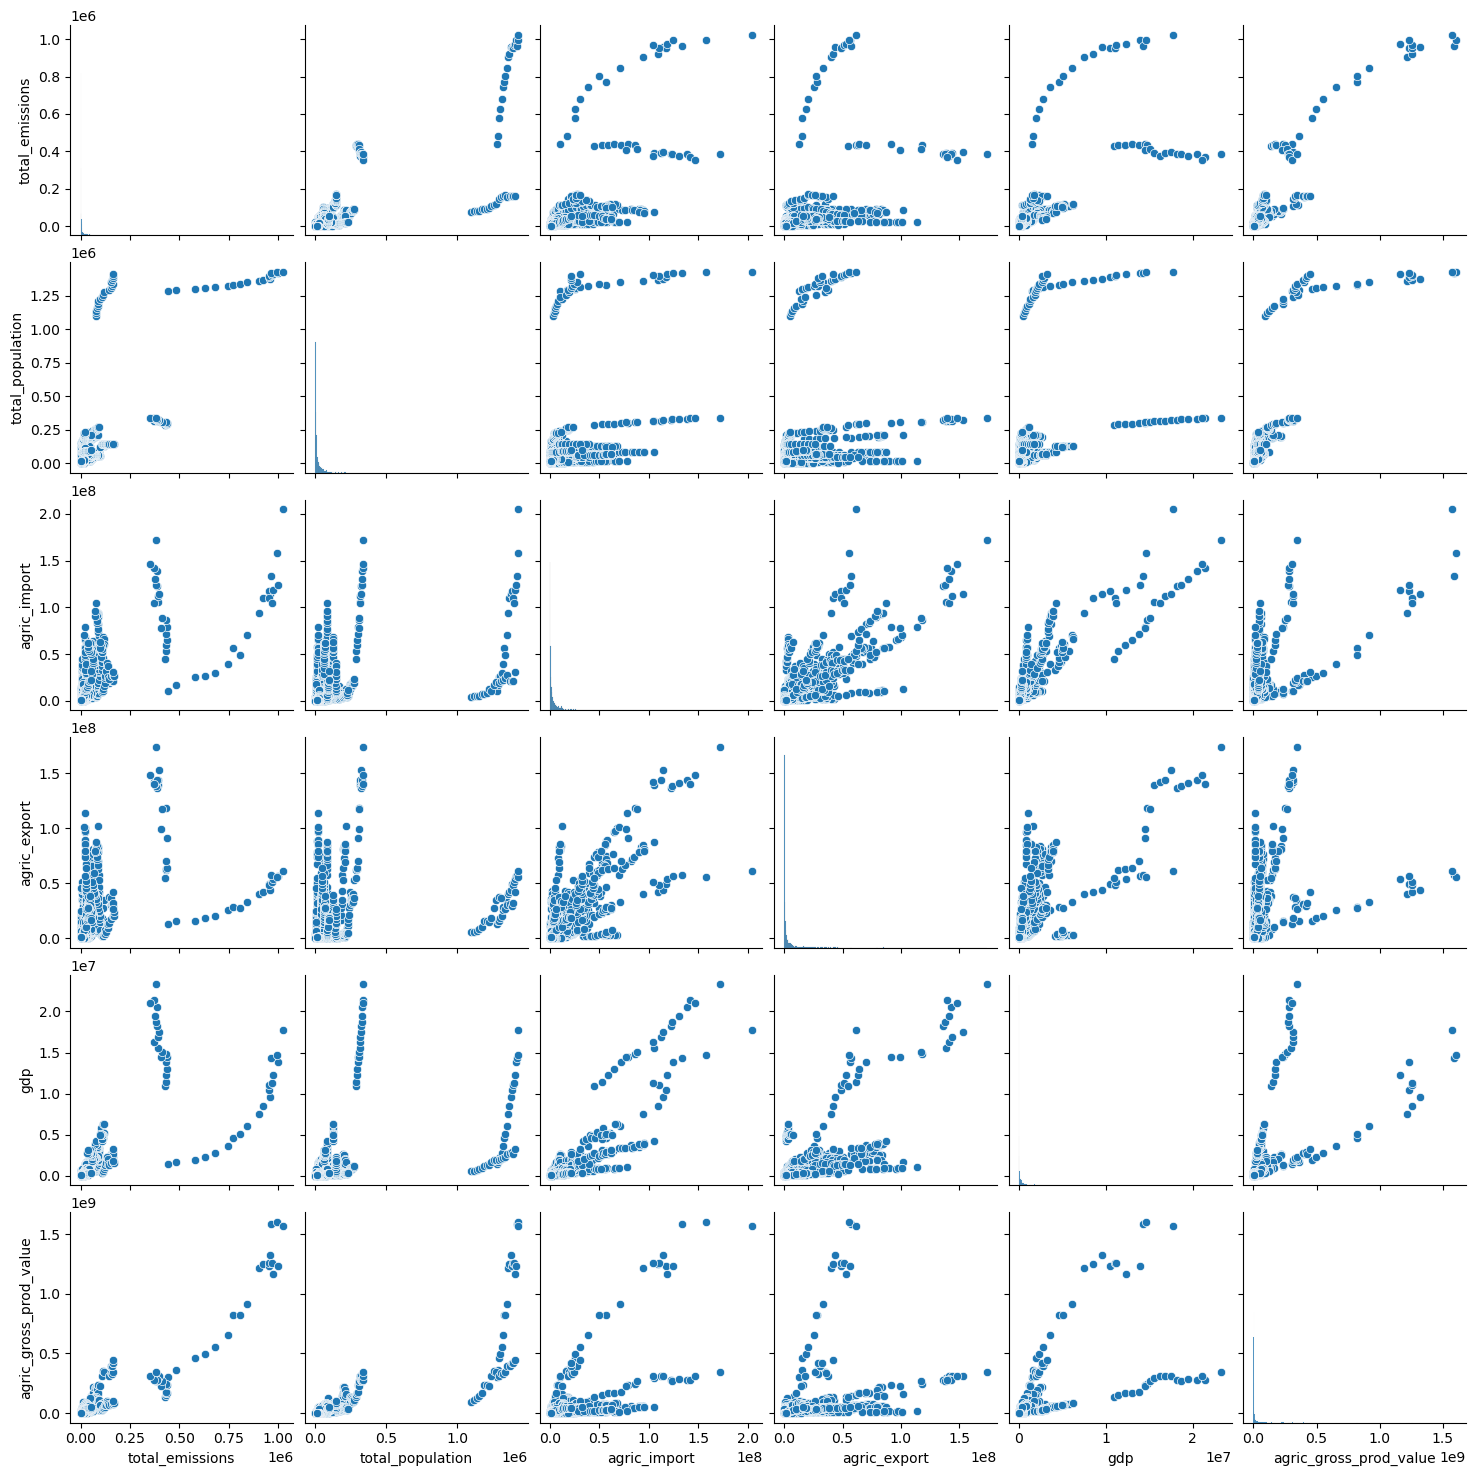

In [79]:
# Create pairplot for all variables within df_subset
pairplot_all = sns.pairplot(df_subset)

In [80]:
# Export pairplot
pairplot_all.figure.savefig(os.path.join(path, '03 Analysis', 'Visualizations', 'pairplot_enriched.png'),bbox_inches='tight')


Also, agric_gross_prod_value and total_emissions have a strong correlation coefficient (0.94). Pairplot shows that there might be a linear relationship between them, so the linear regression model can be built for these variables.